<code>damped_anomaly_forecast_RMSE.ipynb</code>.  This notebook calculates the RMSE, MAE, and raw error for the damped anomaly forecast.  

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from S2S_sea_ice_metrics import calculate_errors,get_pvalues
from S2S_sea_ice_VRILEs import get_VRILE_days
from S2S_sea_ice_preprocess import create_obs_climatology,create_aggregate_regions

The S2S <code>create_aggregate_regions</code> function doesn't work for damped anomaly due to formatting issues.

In [2]:
def create_aggregate_regions_DAMPED_ANOM(SIE_data):
    regions_agg_list = [['Kara Sea','Laptev Sea'],['Barents Sea','Kara Sea','Laptev Sea'],['East Siberian Sea','Beaufort Sea','Chukchi Sea'],
                       ['Baffin Bay','East Greenland Sea'],['East Siberian Sea','Beaufort Sea','Chukchi Sea','Laptev Sea']]
    region_names_extra = ['Kara-Laptev Sea','Barents-Kara-Laptev Sea','East Siberian-Beaufort-Chukchi Sea',
                      'Atlantic','East Siberian-Beaufort-Chukchi-Laptev Sea']
    #
    for i_reg in np.arange(0,len(regions_agg_list)):
        i_reg_sel = regions_agg_list[i_reg]
        SIE_ireg = SIE_data[SIE_data['region'].isin(i_reg_sel)]
        SIE_ireg_group = SIE_ireg.set_index(['region','init date','valid date','lead time']).sum(level=(1,2,3))
        SIE_ireg_group['region'] = region_names_extra[i_reg]
        SIE_data =SIE_data.append(SIE_ireg_group.reset_index())
        
    return(SIE_data)

Okay. Overview of our cross-validated, significance-tested VRILE error. 
* Load model netCDF files, combine with CTRL, and use common reforecast period. 
    *  if NCEP, use entire period 
* Add aggregate regions 
* Create climatology--model: calculate date of year for valid date, lead time in weeks.
    *  Group by region, lead time, and valid date of year 
    *  Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>.
    *  Subtract <code>SIE_clim</code> from <code>SIE</code>
* Create observed climatology based on common reforecast period (1999-2014)
* Set up LeaveOneOut cross-validation: We remove each year (1999-2014) from the observations.  Then we:
    * Calculate VRILEs excluding each year
    * Identify forecasts that correspond to VRILE days and separate S2S model data into VRILE days and non-VRILE days
    * Calculate errors: as a function of region, valid date, and lead time. 
    * Assess significance:
        * H0: RMSE for non-VRILE days = RMSE for VRILE days 
        * Calculate p-value: $p_0 = \frac{(RMSE_{VRILE} - RMSE_{NOVRILE})}{\sqrt{\frac{S_{VRILE}^2}{N_{VRILE}} + \frac{S_{NOVRILE}^2}{N_{NOVRILE}}}}$
        * Save p-values, standard deviations as a function of lead time, region, and year left out. 
        * When $|p| > |p_{crit}|$ ($p_{crit} = \pm 1.96$), we can say that the model's ability to predict sea ice on VRILE days is significantly different from the model's ability to predict sea ice on non-VRILE days in that region for that lead time while leaving out that year
  
* How many years must be significantly different for us to say our samples are overall different? Use a binomial test
    * $\sum_{i}^{N} {N \choose i}p^i(1 - p)^{N - i}$
    * N: total number of samples (15, one for each year between 1999-2014)
    * p: 0.5 (assume we have equal probability of rejecting or not-rejecting null hypothesis)
    * we need to find i: i = 13 for rejecting hypothesis at 95% confidence

In [3]:
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5
seas_sel = [6,7,8]
seas_str = 'JJA'
nyear_roll = 10
lead_weeks = True
ROLL_CLIM = True
COMMON_RF = True

Load the damped anomaly model

In [4]:
obs_name = 'NSIDC_0079'
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
fname_load = fpath_load+'OBS_{obs_name}/DAMPED_ANOMALY_FORECAST_{nyear_roll}_rolling_mean.csv'.format(obs_name=obs_name,nyear_roll=nyear_roll)
SIE_damped_a = pd.read_csv(fname_load)

In [5]:
SIE_damped_a = create_aggregate_regions_DAMPED_ANOM(SIE_damped_a)
SIE_damped_a['init year'] = pd.to_datetime(SIE_damped_a['init date']).dt.year
SIE_damped_a['lead time (days)'] = pd.to_timedelta(SIE_damped_a['lead time'],'D')
# Trim to common reforecast period
#SIE_damped_a = create_aggregate_regions(SIE_damped_a)
if COMMON_RF == True:
    SIE_damped_a = SIE_damped_a[SIE_damped_a['init year'].isin(np.arange(1999,2015))]
SIE_damped = SIE_damped_a.set_index('region')
SIE_damped['valid date'] = pd.to_datetime(SIE_damped['valid date'])
SIE_damped['model name'] = 'DAMPED ANOMALY'

Load obs

In [6]:
if obs_name == 'NSIDC_0079':
    obs_type = 'sipn_nc_yearly_agg_commonland'
else:
    obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11627)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2020-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [7]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
obs_SIE['init year'] = pd.to_datetime(obs_SIE['valid date']).dt.year


Create climatology.  We use a static mean of the 15 years we include in our data set to match how we treated the S2S data.

In [8]:
obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1999,2015))]
#obs_SIE = obs_SIE[obs_SIE['init year'].isin(np.arange(1,2017))]
obs_SIE = create_obs_climatology(obs_SIE)
print('static climatology')
obs_SIE['valid year'] = pd.to_datetime(obs_SIE['valid date']).dt.year

static climatology


Now, we begin the LeaveOneOut process.  We want to do this analysis several times over different datasets, to make sure that we are not overfitting our results.  Since we have only 15 years in our common reforecast period, we'll use a LeaveOneOut, as our training dataset is relatively small.  We start this BEFORE we calculate VRILES so that our data set is calculated separately.

We're going to do this by hand even though it's janky because LOO doesn't play so nice with groupby. 

In [9]:
import warnings
warnings.filterwarnings('ignore');

Initialize dataframes

In [10]:
SIE_errors_ALL = pd.DataFrame()
SIE_anom_errors_ALL = pd.DataFrame()
SIE_errors_NO_ALL = pd.DataFrame()
SIE_anom_errors_NO_ALL = pd.DataFrame()
#
SIE_reg = SIE_damped

#
pvalues_SIE = pd.DataFrame()
pvalues_SIE_anom = pd.DataFrame()
week_length = 7
regions_list = SIE_damped_a['region'].unique().tolist()


Run LeaveOneOut CV

In [11]:
yrs = obs_SIE['valid year'].unique().tolist()
for iyr in yrs:
    #iyr = 1999
    # Remove iyr from obs
    obs_SIE_sel = obs_SIE[~obs_SIE['valid year'].isin([iyr])]
    print('leaving out ',iyr)
    # Estimate observed VRILE days (without iyr)
    obs_SIE_VRILE_onlyx, obs_SIE_anom_VRILE_onlyx, obs_SIE_NO_VRILEx, obs_SIE_anom_NO_VRILEx = get_VRILE_days(obs_SIE_sel,vrile_thresh,nday_change,seas_sel)
    print('VRILE days calculated')
    obs_SIE_VRILE_only = obs_SIE_VRILE_onlyx.set_index(['region'])
    obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_onlyx.set_index(['region'])
    #
    obs_SIE_NO_VRILE = obs_SIE_NO_VRILEx.set_index(['region'])
    obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILEx.set_index(['region'])
    # Now, we want to compare model forecasts on VRILE days to model forecasts on non-VRILE days
    SIE_no_VRILES = pd.DataFrame()
    SIE_anom_no_VRILES = pd.DataFrame()
    #
    SIE_VRILES = pd.DataFrame()
    SIE_anom_VRILES = pd.DataFrame()
    # Get SIE forecasts on VRILE and non-VRILE days for each region.  Loop through regions. 
    for i_region in regions_list:
        # Skip St John because it's crazy
        if (i_region == 'St John') | (i_region == 'Sea of Okhotsk'):
            continue
        elif (i_region == 'Bering') & (seas_str == 'JAS'):
            continue
        SIE_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_VRILE_only.loc[i_region]['valid date']))]
        SIE_VRILES = SIE_VRILES.append(SIE_ivrile)
        #
        SIE_anom_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_VRILE_only.loc[i_region]['valid date']))]
        SIE_anom_VRILES = SIE_anom_VRILES.append(SIE_anom_ivrile)
        #
        if (obs_SIE_NO_VRILE.loc[i_region].shape[0] == 16):
            continue
        SIE_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_NO_VRILE.loc[i_region]['valid date']))]
        SIE_no_VRILES = SIE_no_VRILES.append(SIE_no_ivrile)
        #
        SIE_anom_no_ivrile = SIE_reg.loc[i_region][pd.to_datetime(SIE_reg.loc[i_region]['valid date']).isin(pd.to_datetime(obs_SIE_anom_NO_VRILE.loc[i_region]['valid date']))]
        SIE_anom_no_VRILES = SIE_anom_no_VRILES.append(SIE_anom_no_ivrile)
    # Now, we get lead time in weeks because ultimately we're going to plot as a function of week 
    SIE_anom_VRILES['lead time (weeks)'] = np.floor(SIE_anom_VRILES['lead time (days)'].dt.days/week_length)
    SIE_VRILES['lead time (weeks)'] = np.floor(SIE_VRILES['lead time (days)'].dt.days/week_length)
    SIE_anom_no_VRILES['lead time (weeks)'] = np.floor(SIE_anom_no_VRILES['lead time (days)'].dt.days/week_length)
    SIE_no_VRILES['lead time (weeks)'] = np.floor(SIE_no_VRILES['lead time (days)'].dt.days/week_length)
    # Calculate RMSE and MAE for sea ice forecasts
    if lead_weeks == True:
        clim_freq_str = 'WEEKLY'
        SIE_VRILES['lead days'] = SIE_VRILES['lead time (weeks)']
        SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (weeks)']
        SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
        SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
        ## NO VRILES
        SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (weeks)']
        SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (weeks)']
        SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
        SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
    else:
        clim_freq_str = 'DAILY'
        SIE_VRILES['lead days'] = SIE_VRILES['lead time (days)'].dt.days
        SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (days)'].dt.days
        SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_SIE_VRILE_only)
        SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_SIE_anom_VRILE_only)
        ## NO VRILES
        SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (days)'].dt.days
        SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (days)'].dt.days
        SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_SIE_NO_VRILE)
        SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_SIE_anom_NO_VRILE)
    print('errors calculated')

    # Get p-values
    sd_VRILE,sd_noVRILE,p_value,N_vrile,N_novrile = get_pvalues(SIE_VRILES,SIE_no_VRILES,SIE_errors,SIE_errors_NO)
    sd_VRILE_anom,sd_noVRILE_anom,p_value_anom,N_vrile_anom,N_novrile_anom = get_pvalues(SIE_anom_VRILES,
                                                            SIE_anom_no_VRILES,SIE_anom_errors,SIE_anom_errors_NO)

    # Add information to dataframes
    SIE_errors['year out'] = iyr
    SIE_errors['SIE sdev'] = sd_VRILE
    SIE_errors['sample size'] = N_vrile
    SIE_errors['p-value'] = p_value
    SIE_errors_NO['year out'] = iyr
    SIE_errors_NO['SIE sdev'] = sd_noVRILE
    SIE_errors_NO['sample size'] = N_novrile
    SIE_errors_NO['p-value'] = p_value
    #
    SIE_anom_errors['year out'] = iyr
    SIE_anom_errors['SIE sdev'] = sd_VRILE_anom
    SIE_anom_errors['sample size'] = N_vrile_anom
    SIE_anom_errors['p-value'] = p_value_anom
    SIE_anom_errors_NO['year out'] = iyr
    SIE_anom_errors_NO['SIE sdev'] = sd_noVRILE_anom
    SIE_anom_errors_NO['sample size'] = N_novrile_anom
    SIE_anom_errors_NO['p-value'] = p_value_anom
    # Append each CV slice to full data set
    SIE_errors_ALL = SIE_errors_ALL.append(SIE_errors)
    SIE_anom_errors_ALL = SIE_anom_errors_ALL.append(SIE_anom_errors)
    SIE_errors_NO_ALL = SIE_errors_NO_ALL.append(SIE_errors_NO)
    SIE_anom_errors_NO_ALL = SIE_anom_errors_NO_ALL.append(SIE_anom_errors_NO)

leaving out  1999
VRILE days calculated
errors calculated
leaving out  2000
VRILE days calculated
errors calculated
leaving out  2001
VRILE days calculated
errors calculated
leaving out  2002
VRILE days calculated
errors calculated
leaving out  2003
VRILE days calculated
errors calculated
leaving out  2004
VRILE days calculated
errors calculated
leaving out  2005
VRILE days calculated
errors calculated
leaving out  2006
VRILE days calculated
errors calculated
leaving out  2007
VRILE days calculated
errors calculated
leaving out  2008
VRILE days calculated
errors calculated
leaving out  2009
VRILE days calculated
errors calculated
leaving out  2010
VRILE days calculated
errors calculated
leaving out  2011
VRILE days calculated
errors calculated
leaving out  2012
VRILE days calculated
errors calculated
leaving out  2013
VRILE days calculated
errors calculated
leaving out  2014
VRILE days calculated
errors calculated


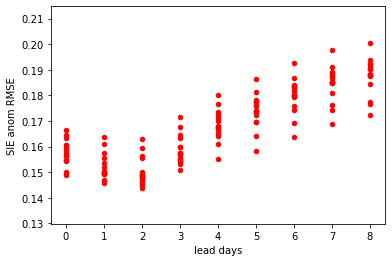

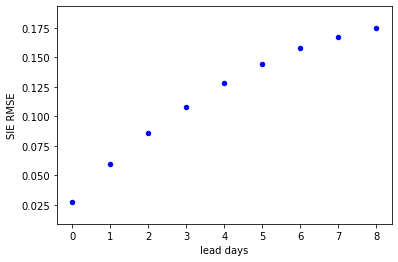

In [12]:
SIE_errors_ALL.xs('Kara-Laptev Sea').reset_index().plot.scatter(x='lead days',y='SIE anom RMSE',color='r')
SIE_errors_NO.xs('Kara-Laptev Sea').reset_index().plot.scatter(x='lead days',y='SIE RMSE',color='b')


Plot RMSE of all folds

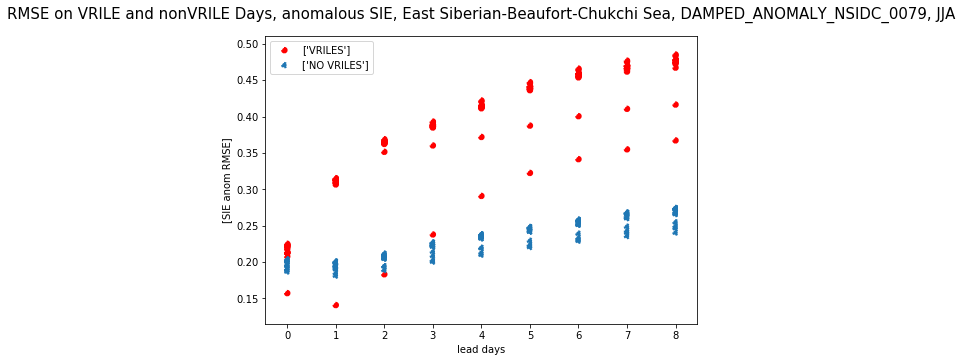

In [13]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
model_name = 'DAMPED_ANOMALY_{obs_name}'.format(obs_name=obs_name)
reg_sel = 'East Siberian-Beaufort-Chukchi Sea'
foo = SIE_errors_ALL.xs(reg_sel).reset_index()
foo.plot.scatter(x='lead days',y=['SIE anom RMSE'],linewidth=2,linestyle='--',ax=ax1,color='r',label=['VRILES'])
foo2 = SIE_errors_NO_ALL.xs(reg_sel).reset_index()
foo2.plot.scatter(x='lead days',y=['SIE anom RMSE'],linewidth=2,linestyle=':',ax=ax1,label=['NO VRILES'])
#
figpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/diagnostics/'
fig1.suptitle('RMSE on VRILE and nonVRILE Days, anomalous SIE, {region}, {model_name}, {seas_str}'.format(region=reg_sel,
                                                                               model_name=model_name,seas_str=seas_str),fontsize=15,
             y=1.1)

fpath_save_fig1 = figpath_save+'damped_anom_SIE_anom_RMSE_all_slices_{reg_sel}_{model_name}_{seas_str}.png'.format(reg_sel=reg_sel,
                                                                            model_name=model_name,seas_str=seas_str)
fig1.savefig(fpath_save_fig1,format='png',dpi=350,bbox_inches='tight')

In [14]:
foo.groupby(['lead days']).mean()/foo2.groupby(['lead days']).mean()

,SIE RMSE,SIE anom RMSE,SIE MAE,SIE anom MAE,year out,SIE sdev,sample size,p-value
lead days,,,,,,,,
0.0,3.178505,1.086611,3.974852,1.389433,1.0,0.941687,0.052632,1.0
1.0,2.910129,1.546155,3.574842,1.606743,1.0,0.831379,0.052632,1.0
2.0,2.329932,1.721710,2.883332,1.775062,1.0,0.792170,0.052632,1.0
3.0,2.019485,1.715946,2.518907,1.889944,1.0,0.761710,0.052632,1.0
4.0,1.936046,1.755248,2.417285,2.004979,1.0,0.745829,0.052632,1.0
5.0,1.913773,1.789873,2.369037,2.049634,1.0,0.744760,0.052632,1.0
6.0,1.906331,1.790976,2.354028,2.057418,1.0,0.745471,0.052632,1.0
7.0,1.894299,1.765940,2.362052,2.031032,1.0,0.742118,0.052632,1.0
8.0,1.891807,1.756283,2.373440,2.022679,1.0,0.744258,0.052632,1.0


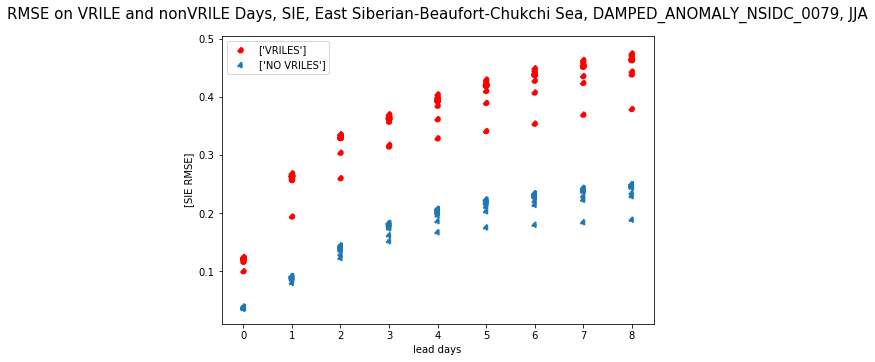

In [15]:
fig2 = plt.figure(2)
ax2 = fig2.add_axes([0,0,1,1])
foo = SIE_errors_ALL.xs(reg_sel).reset_index()
foo.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle='--',ax=ax2,color='r',label=['VRILES'])
foo2 = SIE_errors_NO_ALL.xs(reg_sel).reset_index()
foo2.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle=':',ax=ax2,label=['NO VRILES'])
#
fig2.suptitle('RMSE on VRILE and nonVRILE Days, SIE, {region}, {model_name}, {seas_str}'.format(region=reg_sel,
                                                                               model_name=model_name,
                                                        seas_str=seas_str),fontsize=15,y=1.1)

fpath_save_fig2 = figpath_save+'damped_anom_SIE_RMSE_all_slices_{reg_sel}_{model_name}_{seas_str}.png'.format(reg_sel=reg_sel,
                                                                            model_name=model_name,seas_str=seas_str)
fig2.savefig(fpath_save_fig2,format='png',dpi=350,bbox_inches='tight')

Plot p-value of all folds

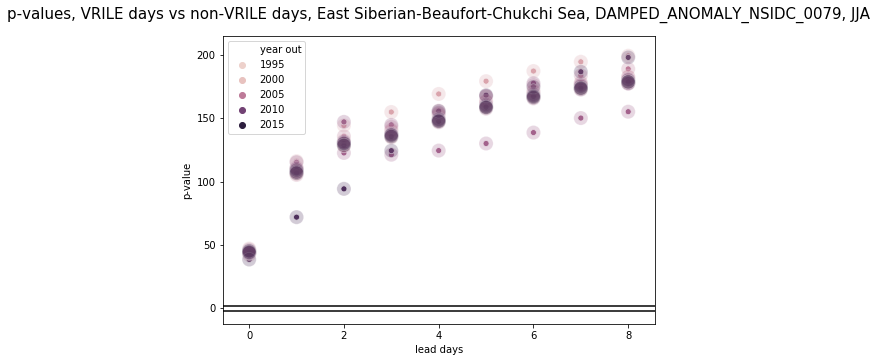

In [16]:
import seaborn as sns
fig3 = plt.figure(3)
ax3 = fig3.add_axes([0,0,1,1])
foo = SIE_errors_ALL.xs(reg_sel).reset_index()
sns.scatterplot(data=foo,x='lead days',y='p-value',hue='year out')
ax3.axhline(-1.96,color='k')
ax3.axhline(1.96,color='k')
SIE_errors_ALL_masked = SIE_errors_ALL.mask(SIE_errors_ALL['p-value'].abs()<1.96)
foo2 = SIE_errors_ALL_masked.xs(reg_sel).reset_index()
sns.scatterplot(data=foo2,x='lead days',y='p-value',hue='year out',s=200,legend=False,alpha=0.25)
fig3.suptitle('p-values, VRILE days vs non-VRILE days, {reg_sel}, {model_name}, {seas_str}'.format(reg_sel=reg_sel,
                                                            model_name=model_name,seas_str=seas_str),fontsize=15,y=1.1)
fpath_save_fig3 = figpath_save+'pvalues_each_fold_{reg_sel}_{model_name}_{seas_str}.png'.format(reg_sel=reg_sel,
                                                                    model_name=model_name,seas_str=seas_str)
fig3.savefig(fpath_save_fig3,format='png',dpi=350,bbox_inches='tight')


Combine everything together into one data frame. Replace <code>SIE anom RMSE</code> and <code>SIE anom MAE</code> in <code>SIE_errors</code> with corresponding entries from  <code>SIE_anom_errors</code> (and same for raw)

In [17]:
SIE_anom_errors_ALL = SIE_anom_errors_ALL.rename(columns={'p-value':'p-value anom'})
SIE_anom_errors_NO_ALL = SIE_anom_errors_NO_ALL.rename(columns={'p-value':'p-value anom'})

In [18]:
SIE_errors_VRILE = SIE_errors_ALL.copy()
SIE_errors_VRILE = SIE_errors_VRILE.drop(columns={'SIE anom RMSE','SIE anom MAE'})
SIE_errors_VRILE = SIE_errors_VRILE.join(SIE_anom_errors_ALL[['SIE anom RMSE','SIE anom MAE','p-value anom']])
SIE_errors_VRILE['type'] = 'VRILE days'
#
SIE_errors_noVRILE = SIE_errors_NO_ALL.copy()
SIE_errors_noVRILE = SIE_errors_noVRILE.drop(columns={'SIE anom RMSE','SIE anom MAE'})
SIE_errors_noVRILE = SIE_errors_noVRILE.join(SIE_anom_errors_NO_ALL[['SIE anom RMSE','SIE anom MAE','p-value anom']])
SIE_errors_noVRILE['type'] = 'no VRILE days'
#
SIE_errors_FULL = SIE_errors_VRILE.append(SIE_errors_noVRILE)
##
SIE_anom_errors_VRILE = SIE_anom_errors_ALL.copy()
SIE_anom_errors_VRILE['type'] = 'VRILE days'
SIE_anom_errors_noVRILE = SIE_anom_errors_NO_ALL.copy()
SIE_anom_errors_noVRILE['type'] = 'no VRILE days'
SIE_anom_errors_FULL = SIE_anom_errors_VRILE.append(SIE_anom_errors_noVRILE)

In [19]:
SIE_errors_FULL

SIE RMSE   SIE MAE  year out  SIE sdev  sample size  \
region    lead days                                                        
Atlantic  0.0        0.055918  0.047534      1999  0.284676        74520   
          0.0        0.055918  0.047534      1999  0.284676        74520   
          0.0        0.055918  0.047534      1999  0.284676        74520   
          0.0        0.055918  0.047534      1999  0.284676        74520   
          0.0        0.055918  0.047534      1999  0.284676        74520   
...                       ...       ...       ...       ...          ...   
panArctic 8.0        0.471049  0.352887      2014  1.783933      1415880   
          8.0        0.471049  0.352887      2014  1.783933      1415880   
          8.0        0.471049  0.352887      2014  1.783933      1415880   
          8.0        0.471049  0.352887      2014  1.783933      1415880   
          8.0        0.471049  0.352887      2014  1.783933      1415880   

                       p-value  SIE anom RMSE  SIE anom MAE  p-value anom  \
region    lead days                                                         
Atlantic  0.0        28.001335       0.096810      0.076411     21.617817   
          0.0        28.001335       0.102932      0.082100     20.677360   
          0.0        28.001335       0.085177      0.068494     21.793382   
          0.0        28.001335       0.100599      0.080547     21.559734   
          0.0        28.001335       0.106257      0.085010     20.938463   
...                        ...            ...           ...           ...   
panArctic 8.0        14.009278       0.551449      0.441891     11.232550   
          8.0        14.009278       0.542507      0.430439     10.188285   
          8.0        14.009278       0.514886      0.412786      5.224619   
          8.0        14.009278       0.553376      0.444007     15.268614   
          8.0        14.009278       0.556857      0.448290     11.645618   

                              type  
region    lead days                 
Atlantic  0.0           VRILE days  
          0.0           VRILE days  
          0.0           VRILE days  
          0.0           VRILE days  
          0.0           VRILE days  
...                            ...  
panArctic 8.0        no VRILE days  
          8.0        no VRILE days  
          8.0        no VRILE days  
          8.0        no VRILE days  
          8.0        no VRILE days  

[82944 rows x 10 columns]

Save files 

In [20]:
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/{model_name}/'.format(model_name=model_name)
fdir = fdir+'OBS_{obs_name}/'.format(obs_name=obs_name)
if COMMON_RF == True:
    fdir = fdir+'COMMON_RF/'
else:
    fdir = fdir+'FULL_TIME/'
if nday_change != 5:
    fdir = fdir+'VRILEs_{nday_change}day_change/'.format(nday_change=nday_change)
if not os.path.exists(fdir):
    os.makedirs(fdir)
#

fname_save_RMSE = fdir+'VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)

#fname_save_raw = fdir+'RAW_err_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
 #                                            seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
#
#SIE_raw_err_FULL.to_csv(fname_save_raw)
SIE_errors_FULL.to_csv(fname_save_RMSE)

In [21]:
fname_save_RMSE

'/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/DAMPED_ANOMALY_NSIDC_0079/OBS_NSIDC_0079/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_DAMPED_ANOMALY_NSIDC_0079_monthsJJA_VRILE05_model_clim_freq_WEEKLY.csv'